In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True
)

100%|██████████| 170M/170M [00:18<00:00, 9.09MB/s]


In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 32×16×16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 64×8×8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # 128×4×4
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [5]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8×8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # 16×16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # 32×32
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        return self.deconv(x)

In [7]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar, z

In [10]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss, kl_div, recon_loss + kl_div

In [11]:
latent_dim = 2   # keep 2 for visualization
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 20

In [12]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        recon, mu, logvar, _ = model(x)
        recon_loss, kl_loss, loss = vae_loss(recon, x, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(train_loader.dataset):.4f}")

Epoch [1/20] | Loss: 125.5118
Epoch [2/20] | Loss: 118.3496
Epoch [3/20] | Loss: 117.9119
Epoch [4/20] | Loss: 117.6966
Epoch [5/20] | Loss: 117.4572
Epoch [6/20] | Loss: 117.3604
Epoch [7/20] | Loss: 117.1385
Epoch [8/20] | Loss: 117.0448
Epoch [9/20] | Loss: 116.9338
Epoch [10/20] | Loss: 116.8787
Epoch [11/20] | Loss: 116.8755
Epoch [12/20] | Loss: 116.5295
Epoch [13/20] | Loss: 116.5175
Epoch [14/20] | Loss: 116.3429
Epoch [15/20] | Loss: 116.2175
Epoch [16/20] | Loss: 116.1293
Epoch [17/20] | Loss: 116.0801
Epoch [18/20] | Loss: 116.0329
Epoch [19/20] | Loss: 115.8964
Epoch [20/20] | Loss: 115.8005


In [13]:
model.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.to(device)
    recon, _, _, _ = model(x)

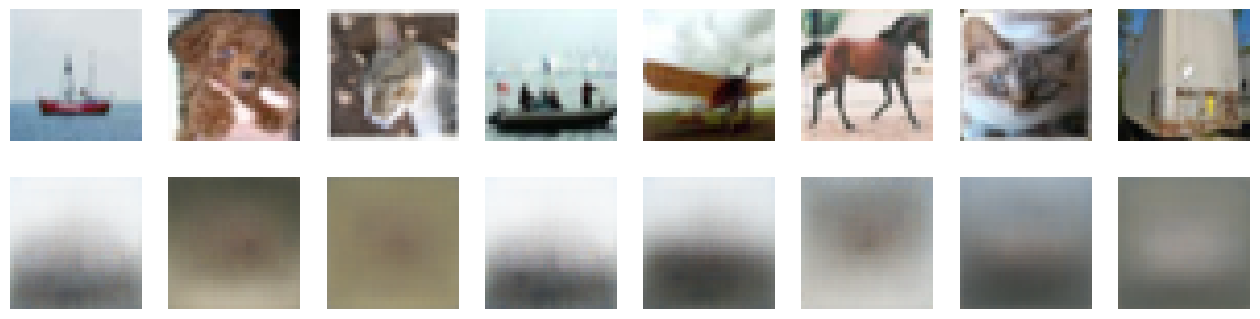

In [14]:
def show_reconstructions(original, recon, n=8):
    original = original.cpu()
    recon = recon.cpu()

    plt.figure(figsize=(16, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(np.transpose(original[i], (1,2,0)))
        plt.axis("off")

        # Reconstructed
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.transpose(recon[i], (1,2,0)))
        plt.axis("off")

    plt.show()

show_reconstructions(x, recon)

In [16]:
latents = []
labels = []

model.eval()
with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        mu, _ = model.encoder(x)
        latents.append(mu.cpu())
        labels.append(y)

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

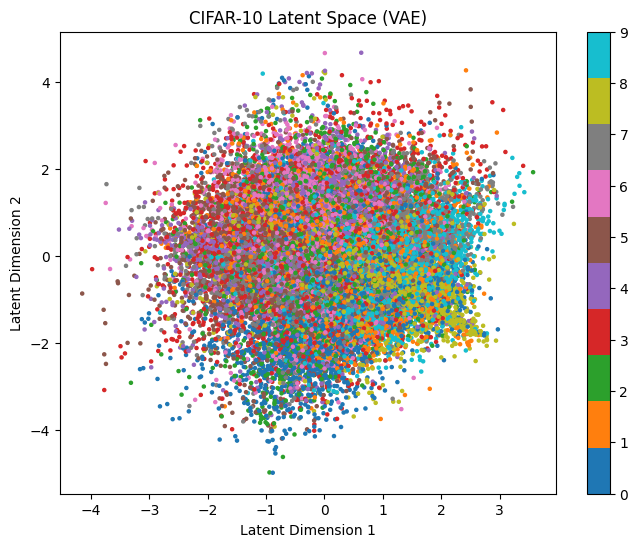

In [17]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    latents[:,0], latents[:,1],
    c=labels, cmap="tab10", s=5
)
plt.colorbar(scatter)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("CIFAR-10 Latent Space (VAE)")
plt.show()

In [18]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.mse_loss(
        recon_x, x, reduction='sum'
    )

    kl_div = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    total_loss = recon_loss + beta * kl_div
    return recon_loss, kl_div, total_loss

In [19]:
beta = 0.5   # try: 0.1, 0.5, 1, 2, 4

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        recon, mu, logvar, _ = model(x)
        recon_loss, kl_loss, loss = vae_loss(
            recon, x, mu, logvar, beta
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(
        f"Epoch {epoch+1} | "
        f"Recon: {recon_loss.item():.0f} | "
        f"KL: {kl_loss.item():.0f} | "
        f"Total: {total_loss/len(train_loader.dataset):.4f}"
    )

Epoch 1 | Recon: 8804 | KL: 423 | Total: 113.1536
Epoch 2 | Recon: 9268 | KL: 427 | Total: 113.0721
Epoch 3 | Recon: 9272 | KL: 466 | Total: 113.1317
Epoch 4 | Recon: 8657 | KL: 465 | Total: 112.8705
Epoch 5 | Recon: 8201 | KL: 418 | Total: 112.8812
Epoch 6 | Recon: 8827 | KL: 474 | Total: 112.8068
Epoch 7 | Recon: 8629 | KL: 467 | Total: 112.7214
Epoch 8 | Recon: 8595 | KL: 447 | Total: 112.6877
Epoch 9 | Recon: 8967 | KL: 476 | Total: 112.4587
Epoch 10 | Recon: 8997 | KL: 451 | Total: 112.5652
Epoch 11 | Recon: 8487 | KL: 454 | Total: 112.3499
Epoch 12 | Recon: 8175 | KL: 469 | Total: 112.5130
Epoch 13 | Recon: 9400 | KL: 460 | Total: 112.4556
Epoch 14 | Recon: 8007 | KL: 486 | Total: 112.3308
Epoch 15 | Recon: 8781 | KL: 495 | Total: 112.1788
Epoch 16 | Recon: 9171 | KL: 513 | Total: 112.2589
Epoch 17 | Recon: 9258 | KL: 459 | Total: 112.0158
Epoch 18 | Recon: 8992 | KL: 464 | Total: 112.0537
Epoch 19 | Recon: 7601 | KL: 466 | Total: 111.9764
Epoch 20 | Recon: 9382 | KL: 471 | Total

In [20]:
def kl_annealing(epoch, max_beta=4.0, warmup_epochs=10):
    return min(max_beta, max_beta * epoch / warmup_epochs)

In [21]:
for epoch in range(epochs):
    model.train()
    beta = kl_annealing(epoch, max_beta=4.0, warmup_epochs=10)

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        recon, mu, logvar, _ = model(x)
        recon_loss, kl_loss, loss = vae_loss(
            recon, x, mu, logvar, beta
        )

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | β = {beta:.2f}")

Epoch 1 | β = 0.00
Epoch 2 | β = 0.40
Epoch 3 | β = 0.80
Epoch 4 | β = 1.20
Epoch 5 | β = 1.60
Epoch 6 | β = 2.00
Epoch 7 | β = 2.40
Epoch 8 | β = 2.80
Epoch 9 | β = 3.20
Epoch 10 | β = 3.60
Epoch 11 | β = 4.00
Epoch 12 | β = 4.00
Epoch 13 | β = 4.00
Epoch 14 | β = 4.00
Epoch 15 | β = 4.00
Epoch 16 | β = 4.00
Epoch 17 | β = 4.00
Epoch 18 | β = 4.00
Epoch 19 | β = 4.00
Epoch 20 | β = 4.00


In [22]:
model.eval()

all_mu = []
all_labels = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        mu, _ = model.encoder(x)   # use mean for stable latent space
        all_mu.append(mu.cpu())
        all_labels.append(y)

all_mu = torch.cat(all_mu).numpy()
all_labels = torch.cat(all_labels).numpy()

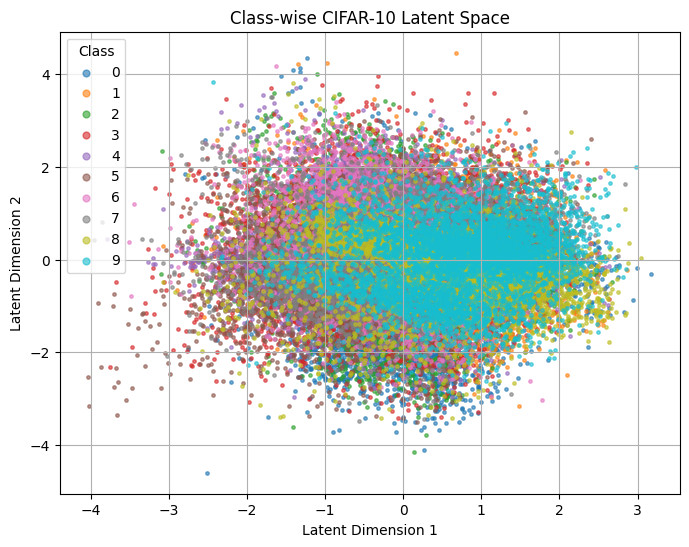

In [24]:
plt.figure(figsize=(8, 6))

for cls in range(10):
    idx = all_labels == cls
    plt.scatter(
        all_mu[idx, 0],
        all_mu[idx, 1],
        s=6,
        alpha=0.6,
        label=str(cls)
    )

plt.legend(title="Class", markerscale=2)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Class-wise CIFAR-10 Latent Space")
plt.grid(True)
plt.show()

In [30]:
num_classes = 10


In [31]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128*4*4 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4 + num_classes, latent_dim)

    def forward(self, x, y):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, y], dim=1)
        return self.fc_mu(x), self.fc_logvar(x)

In [32]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim + num_classes, 128*4*4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        return self.deconv(x)

In [33]:
model.eval()

all_mu = []
all_labels = []

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device)
        mu, _ = model.encoder(x)   # use mean (μ), not sampled z
        all_mu.append(mu.cpu())
        all_labels.append(y)

all_mu = torch.cat(all_mu).numpy()
all_labels = torch.cat(all_labels).numpy()

In [37]:
pip install umap-learn

In [38]:
import umap

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

mu_umap = reducer.fit_transform(all_mu)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


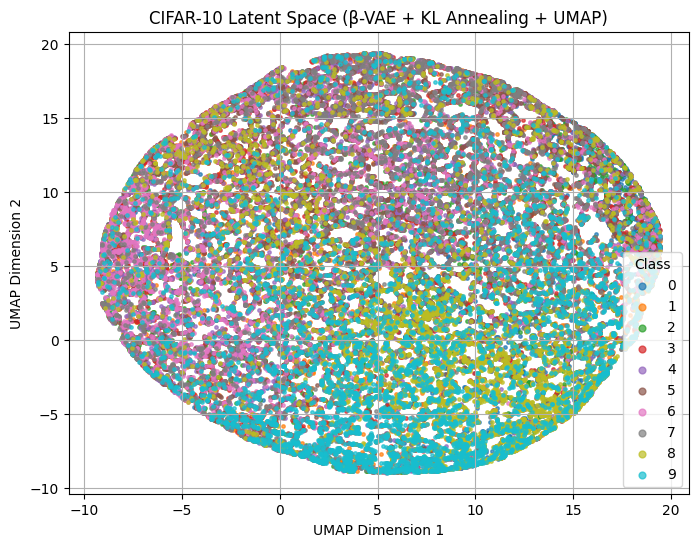

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for cls in range(10):
    idx = all_labels == cls
    plt.scatter(
        mu_umap[idx, 0],
        mu_umap[idx, 1],
        s=6,
        alpha=0.7,
        label=str(cls)
    )

plt.legend(title="Class", markerscale=2)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("CIFAR-10 Latent Space (β-VAE + KL Annealing + UMAP)")
plt.grid(True)
plt.show()